# Tailored BTC Fit: 1D ADE with **Finite-Duration Pulse** (Boundary Input)

This notebook matches your experiment:

- **Pulse injection** at the inlet boundary (x = 0)
- Injection **starts at** `t_start = 5 s` (relative to when sampling begins)
- Injection **duration** `t_pulse = 10 s`
- Concentration measured as **percent** by colorimeter (0–100%)

## Why this model
A finite-duration pulse at the boundary is best represented as the **difference of two step solutions**:

\[
C_{pulse}(t) = C_{step}(t - t_{start}) - C_{step}(t - (t_{start}+t_{pulse}))
\]

where \(C_{step}(t)\) is the **Ogata–Banks** step-input solution for 1D advection–dispersion.

We fit:
- pore-water velocity \(v\) [cm/s]
- dispersion coefficient \(D\) [cm²/s]
- scale \(S\) (should be near 100 if data are already % of influent)
- baseline \(B\) (small offset, e.g. instrument baseline)

Optionally: a small time-shift \(\Delta t\) to account for tubing / timing offsets.

---


## 1) Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from scipy.optimize import curve_fit
from scipy.special import erfc

plt.rcParams["figure.dpi"] = 130


## 2) Experiment Constants (your values)

Edit only if needed.


In [16]:
# ---- Column / medium ----
L_cm    = 14.3      # column length [cm]
ID_cm   = 4.7       # inner diameter [cm]
theta   = 0.40      # porosity [-]

# ---- Flow ----
Q_cm3_s = 4.356     # [cm^3/s]  (same as mL/s)

# ---- Injection timing (relative to sampling start) ----
t_start_s = 5.0     # injection begins at 5 s
t_pulse_s = 10.0    # injection lasts 10 s

# ---- Derived hydraulics (for reference) ----
r_cm = ID_cm / 2.0
A_cm2 = pi * r_cm**2
q_cm_s = Q_cm3_s / A_cm2
v_calc = q_cm_s / theta

print(f"A = {A_cm2:.3f} cm^2")
print(f"q = {q_cm_s:.4f} cm/s (Darcy flux)")
print(f"v_calc = {v_calc:.4f} cm/s (pore-water velocity from Q, geometry, theta)")
print(f"Travel time L/v_calc = {L_cm / v_calc:.2f} s")


A = 17.349 cm^2
q = 0.2511 cm/s (Darcy flux)
v_calc = 0.6277 cm/s (pore-water velocity from Q, geometry, theta)
Travel time L/v_calc = 22.78 s


## 3) Load one or two runs from Excel

You said both files have:
- `time_sec` (first column)
- `C_obs_perc` (second column)

We'll support fitting **either** run individually, or a **joint fit** (shared v and D) across both runs.


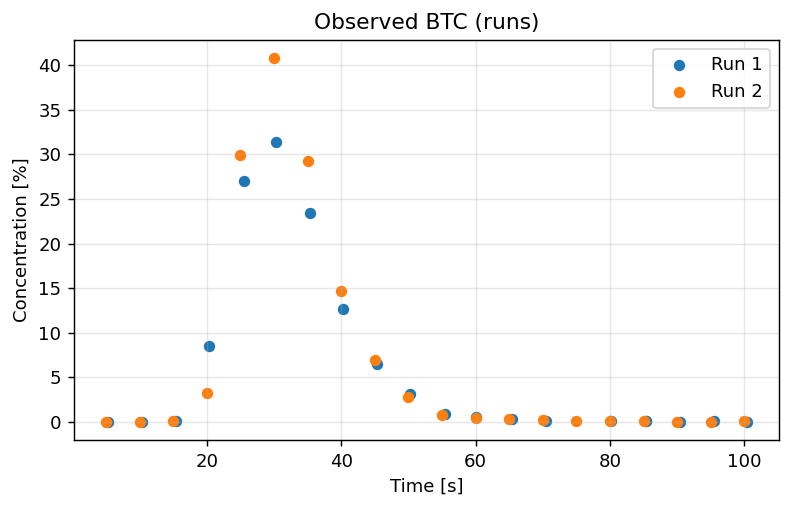

In [17]:
# Choose files (set None to skip)
FILE1 = "breakthrough_data.xlsx"
FILE2 = "breakthrough_data2.xlsx"

TIME_COL = "time_sec"
CONC_COL = "C_obs_perc"

def load_run(path):
    df = pd.read_excel(path)
    t = df[TIME_COL].to_numpy(float)
    c = df[CONC_COL].to_numpy(float)
    o = np.argsort(t)
    return t[o], c[o]

t1, c1 = load_run(FILE1) if FILE1 else (None, None)
t2, c2 = load_run(FILE2) if FILE2 else (None, None)

# Quick plots
plt.figure(figsize=(7,4))
if t1 is not None:
    plt.scatter(t1, c1, s=28, label="Run 1")
if t2 is not None:
    plt.scatter(t2, c2, s=28, label="Run 2")
plt.xlabel("Time [s]")
plt.ylabel("Concentration [%]")
plt.title("Observed BTC (runs)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## 4) ADE Step Solution (Ogata–Banks) and Pulse Construction

### Step input at inlet (x=0):
For constant boundary concentration \(C_0\) applied at \(x=0\) for \(t>0\), the solution at distance \(x\) is:

\[
\frac{C(x,t)}{C_0} =
\frac{1}{2}\,\mathrm{erfc}\left(\frac{x - vt}{2\sqrt{Dt}}\right)
+ \frac{1}{2}\exp\left(\frac{vx}{D}\right)\,\mathrm{erfc}\left(\frac{x + vt}{2\sqrt{Dt}}\right)
\]

### Finite-duration pulse:
\[
C_{pulse}(t) = C_{step}(t-t_{start}) - C_{step}(t-(t_{start}+t_{pulse}))
\]

We then convert to percent via:
\[
C_{pred}(t) = B + S \cdot \frac{C(x,t)}{C_0}
\]

If your data are already \(100\times C/C_0\), then \(S\approx 100\) and \(B\approx 0\).


In [18]:
def ogata_banks_step(x, t, v, D):
    """Dimensionless concentration C/C0 for a step boundary at x=0."""
    t = np.asarray(t, dtype=float)
    out = np.zeros_like(t)
    m = t > 0
    tt = t[m]
    sqrt_term = 2.0 * np.sqrt(D * tt)
    term1 = 0.5 * erfc((x - v * tt) / sqrt_term)
    term2 = 0.5 * np.exp((v * x) / D) * erfc((x + v * tt) / sqrt_term)
    out[m] = term1 + term2
    return out

def ade_pulse_percent(t, v, D, S, B, dt_shift=0.0):
    """Finite-duration pulse prediction in percent units."""
    t = np.asarray(t, dtype=float) + dt_shift
    c1 = ogata_banks_step(L_cm, t - t_start_s, v, D)
    c2 = ogata_banks_step(L_cm, t - (t_start_s + t_pulse_s), v, D)
    return B + S * (c1 - c2)


## 5) Fit Each Run (and optionally a small time shift)

- Set `fit_dt = True` to allow a small time shift ±10 s.
- Weighting is used so the peak/tail influence the fit (otherwise zeros can dominate).



Run 1 fit results
----------------------------------------
q = 0.2511 cm/s (Darcy flux)
v = 0.766459 cm/s (Porewater velocity)
D = 0.921087 cm^2/s (Dispersion coeff.)
Pe = vL/D = 11.899
RMSE = 0.257 %


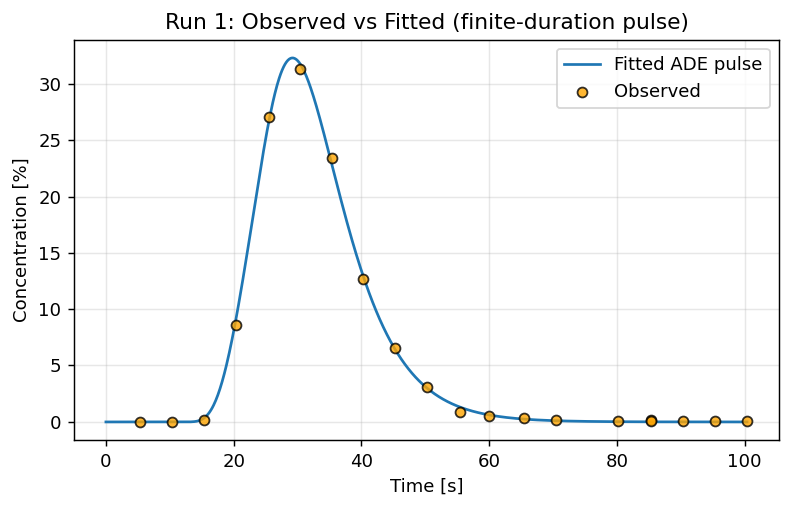


Run 2 fit results
----------------------------------------
q = 0.2511 cm/s (Darcy flux)
v = 1.029045 cm/s (Porewater velocity)
D = 1.952279 cm^2/s (Dispersion coeff.)
Pe = vL/D = 7.538
RMSE = 0.652 %


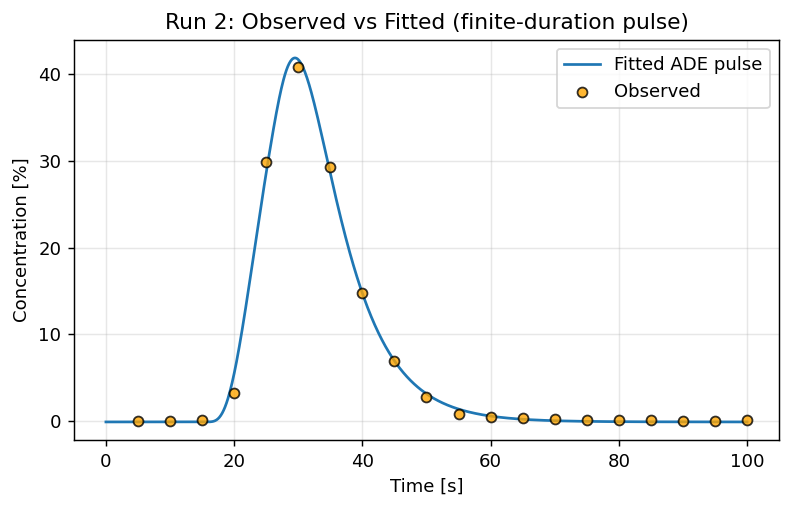

In [19]:
fit_dt = True   # set False to force dt_shift=0

def fit_run(t, c, label="Run"):
    t = np.asarray(t, float)
    c = np.asarray(c, float)

    # heuristic weights: emphasize larger concentrations
    sigma = np.clip(5.0 + 0.2*(100.0 - c), 2.0, 25.0)

    if not fit_dt:
        def model(t, v, D, S, B):
            return ade_pulse_percent(t, v, D, S, B, dt_shift=0.0)
        p0 = [v_calc, 1.0, 100.0, 0.0]
        bounds = ([1e-4, 1e-6, 0.0, -10.0], [20.0, 1e4, 200.0, 10.0])
        popt, _ = curve_fit(model, t, c, p0=p0, bounds=bounds, sigma=sigma, absolute_sigma=False, maxfev=400000)
        v, D, S, B = popt
        dt = 0.0
    else:
        def model(t, v, D, S, B, dt_shift):
            return ade_pulse_percent(t, v, D, S, B, dt_shift=dt_shift)
        p0 = [v_calc, 1.0, 100.0, 0.0, 0.0]
        bounds = ([1e-4, 1e-6, 0.0, -10.0, -10.0], [20.0, 1e4, 200.0, 10.0, 10.0])
        popt, _ = curve_fit(model, t, c, p0=p0, bounds=bounds, sigma=sigma, absolute_sigma=False, maxfev=600000)
        v, D, S, B, dt = popt

    t_dense = np.linspace(0, t.max(), 900)
    y_dense = ade_pulse_percent(t_dense, v, D, S, B, dt_shift=dt)
    y_hat = ade_pulse_percent(t, v, D, S, B, dt_shift=dt)

    rmse = np.sqrt(np.mean((c - y_hat)**2))
    alpha = D / v
    Pe = v * L_cm / D

    print(f"\n{label} fit results")
    print("-"*40)
    print(f"q = {q_cm_s:.4f} cm/s (Darcy flux)")
    print(f"v = {v:.6f} cm/s (Porewater velocity)")
    print(f"D = {D:.6f} cm^2/s (Dispersion coeff.)")
    # print(f"alpha = D/v = {alpha:.6f} cm")
    print(f"Pe = vL/D = {Pe:.3f}")
    # print(f"S = {S:.3f}  (scale, ~100 expected)")
    # print(f"B = {B:.3f} % (baseline)")
    # if fit_dt:
    #     print(f"dt_shift = {dt:.3f} s")
    print(f"RMSE = {rmse:.3f} %")

    plt.figure(figsize=(7,4))
    plt.plot(t_dense, y_dense, label="Fitted ADE pulse", zorder=2.0)
    plt.scatter(t, c, s=30, c="orange", edgecolors='black', alpha=0.8, label="Observed", zorder=2.2)
    plt.xlabel("Time [s]")
    plt.ylabel("Concentration [%]")
    plt.title(f"{label}: Observed vs Fitted (finite-duration pulse)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return dict(v=v, D=D, S=S, B=B, dt_shift=dt, rmse=rmse, alpha=alpha, Pe=Pe)

res1 = fit_run(t1, c1, "Run 1") if t1 is not None else None
res2 = fit_run(t2, c2, "Run 2") if t2 is not None else None


## 6) Joint Fit (shared v and D across both runs)

This is often more stable when each run alone has limited tail information.



JOINT fit results (shared v,D)
--------------------------------------------------
v = 0.934950 cm/s
D = 1.559619 cm^2/s
alpha = 1.668131 cm
Pe = 8.572
Run1: S=54.929, B=0.231, dt=-7.032
Run2: S=68.499, B=-0.353, dt=-7.428
RMSE joint = 0.711 %


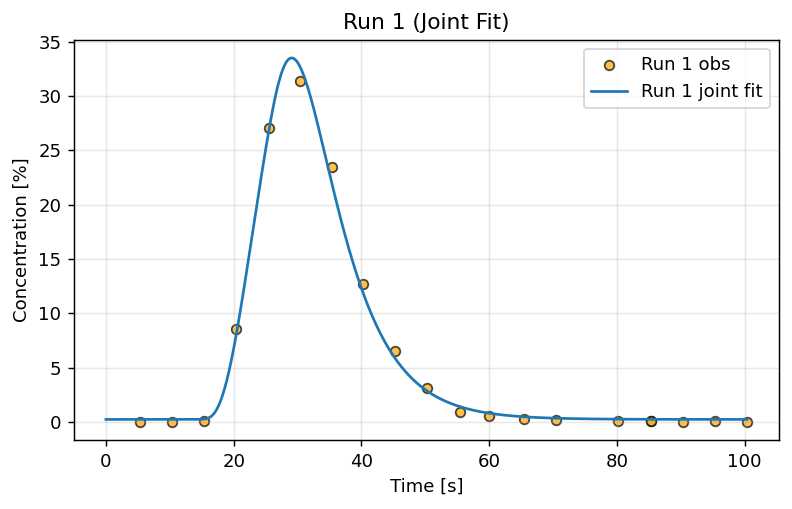

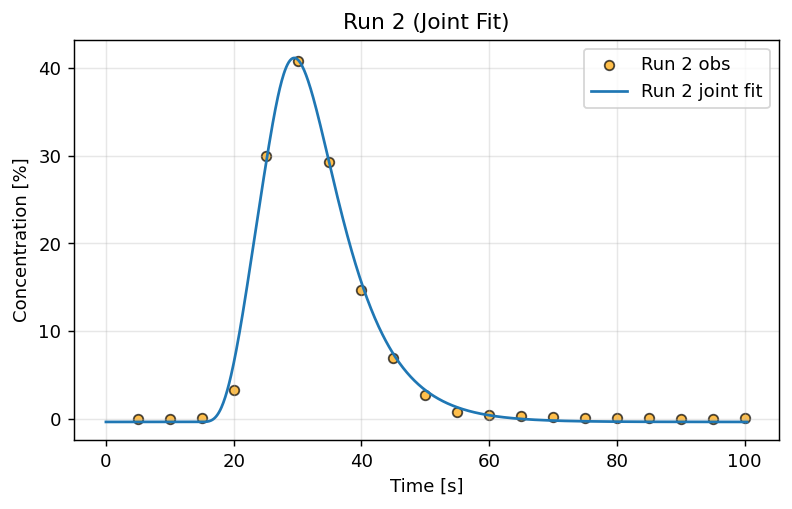

In [20]:
do_joint_fit = (t1 is not None) and (t2 is not None)

if do_joint_fit:
    t_all = np.concatenate([t1, t2])
    y_all = np.concatenate([c1, c2])
    run_id = np.concatenate([np.zeros_like(t1, dtype=int), np.ones_like(t2, dtype=int)])
    sigma_all = np.clip(5.0 + 0.2*(100.0 - y_all), 2.0, 25.0)

    if not fit_dt:
        def joint_pred(v, D, S1, B1, S2, B2):
            pred = np.empty_like(y_all, dtype=float)
            m1 = run_id == 0
            m2 = ~m1
            pred[m1] = ade_pulse_percent(t_all[m1], v, D, S1, B1, dt_shift=0.0)
            pred[m2] = ade_pulse_percent(t_all[m2], v, D, S2, B2, dt_shift=0.0)
            return pred

        def joint_model(_t, v, D, S1, B1, S2, B2):
            return joint_pred(v, D, S1, B1, S2, B2)

        p0 = [v_calc, 1.0, 100.0, 0.0, 100.0, 0.0]
        bounds = ([1e-4, 1e-6, 0.0, -10.0, 0.0, -10.0],
                  [20.0, 1e4, 200.0, 10.0, 200.0, 10.0])

        popt, _ = curve_fit(joint_model, t_all, y_all, p0=p0, bounds=bounds, sigma=sigma_all, absolute_sigma=False, maxfev=900000)
        vJ, DJ, S1J, B1J, S2J, B2J = popt
        dt1J = dt2J = 0.0

    else:
        def joint_pred(v, D, S1, B1, dt1, S2, B2, dt2):
            pred = np.empty_like(y_all, dtype=float)
            m1 = run_id == 0
            m2 = ~m1
            pred[m1] = ade_pulse_percent(t_all[m1], v, D, S1, B1, dt_shift=dt1)
            pred[m2] = ade_pulse_percent(t_all[m2], v, D, S2, B2, dt_shift=dt2)
            return pred

        def joint_model(_t, v, D, S1, B1, dt1, S2, B2, dt2):
            return joint_pred(v, D, S1, B1, dt1, S2, B2, dt2)

        p0 = [v_calc, 1.0, 100.0, 0.0, 0.0, 100.0, 0.0, 0.0]
        bounds = ([1e-4, 1e-6, 0.0, -10.0, -10.0, 0.0, -10.0, -10.0],
                  [20.0, 1e4, 200.0, 10.0, 10.0, 200.0, 10.0, 10.0])

        popt, _ = curve_fit(joint_model, t_all, y_all, p0=p0, bounds=bounds, sigma=sigma_all, absolute_sigma=False, maxfev=1500000)
        vJ, DJ, S1J, B1J, dt1J, S2J, B2J, dt2J = popt

    pred_all = joint_pred(vJ, DJ, S1J, B1J, dt1J, S2J, B2J, dt2J) if fit_dt else joint_pred(vJ, DJ, S1J, B1J, S2J, B2J)
    rmseJ = np.sqrt(np.mean((y_all - pred_all)**2))
    alphaJ = DJ / vJ
    PeJ = vJ * L_cm / DJ

    print("\nJOINT fit results (shared v,D)")
    print("-"*50)
    print(f"v = {vJ:.6f} cm/s")
    print(f"D = {DJ:.6f} cm^2/s")
    print(f"alpha = {alphaJ:.6f} cm")
    print(f"Pe = {PeJ:.3f}")
    print(f"Run1: S={S1J:.3f}, B={B1J:.3f}, dt={dt1J:.3f}")
    print(f"Run2: S={S2J:.3f}, B={B2J:.3f}, dt={dt2J:.3f}")
    print(f"RMSE joint = {rmseJ:.3f} %")

    t_dense = np.linspace(0, max(t1.max(), t2.max()), 1000)
    y1_dense = ade_pulse_percent(t_dense, vJ, DJ, S1J, B1J, dt_shift=dt1J)
    y2_dense = ade_pulse_percent(t_dense, vJ, DJ, S2J, B2J, dt_shift=dt2J)

    plt.figure(figsize=(7,4))
    plt.scatter(t1, c1, s=28, c="orange", edgecolors='black', alpha=0.7, label="Run 1 obs")
    plt.plot(t_dense, y1_dense, label="Run 1 joint fit")
    plt.xlabel("Time [s]")
    plt.ylabel("Concentration [%]")
    plt.title("Run 1 (Joint Fit)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.scatter(t2, c2, s=28, c="orange", edgecolors='black', alpha=0.7, label="Run 2 obs")
    plt.plot(t_dense, y2_dense, label="Run 2 joint fit")
    plt.xlabel("Time [s]")
    plt.ylabel("Concentration [%]")
    plt.title("Run 2 (Joint Fit)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("Joint fit skipped (need both runs loaded).")


## 7) Data quality summary

Counts how many points are above small thresholds and how many points define the falling limb.


In [21]:
def data_quality_report(t, c, label="Run"):
    t = np.asarray(t, float)
    c = np.asarray(c, float)
    nonzero = np.sum(c > 0.1)
    above1 = np.sum(c > 1.0)
    peak_i = int(np.argmax(c))
    t_peak = t[peak_i]
    c_peak = c[peak_i]
    after_peak = np.sum((t > t_peak) & (c > 0.1))

    print(f"\n{label} data report")
    print("-"*30)
    print(f"Total points: {len(t)}")
    print(f">0.1% points: {nonzero}")
    print(f">1% points:   {above1}")
    print(f"Peak: {c_peak:.2f}% at t={t_peak:.1f}s")
    print(f"Points after peak >0.1%: {after_peak}")

if t1 is not None: data_quality_report(t1, c1, "Run 1")
if t2 is not None: data_quality_report(t2, c2, "Run 2")



Run 1 data report
------------------------------
Total points: 20
>0.1% points: 12
>1% points:   7
Peak: 31.36% at t=30.4s
Points after peak >0.1%: 8

Run 2 data report
------------------------------
Total points: 20
>0.1% points: 12
>1% points:   7
Peak: 40.81% at t=30.0s
Points after peak >0.1%: 9
